In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=66,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

In [7]:
DD_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       119392      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           model_1[1][0]                    
__________

In [8]:
#DD_Net.load_weights('weights/fine_lite.h5')

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [ ]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

In [ ]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

In [12]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 1960 samples, validate on 840 samples
Epoch 1/400
1960/1960 [==============================] - 9s 5ms/step - loss: 3.9400 - acc: 0.0342 - val_loss: 3.3576 - val_acc: 0.0429
Epoch 2/400
1960/1960 [==============================] - 1s 319us/step - loss: 3.8103 - acc: 0.0357 - val_loss: 3.2570 - val_acc: 0.0833
Epoch 3/400
1960/1960 [==============================] - 1s 264us/step - loss: 3.6932 - acc: 0.0510 - val_loss: 3.1817 - val_acc: 0.0976
Epoch 4/400
1960/1960 [==============================] - 1s 313us/step - loss: 3.5799 - acc: 0.0500 - val_loss: 3.1183 - val_acc: 0.1167
Epoch 5/400
1960/1960 [==============================] - 0s 254us/step - loss: 3.4485 - acc: 0.0653 - val_loss: 3.0569 - val_acc: 0.1333
Epoch 6/400
1960/1960 [==============================] - 1s 302us/step - loss: 3.3921 - acc: 0.0770 - val_loss: 3.0071 - val_acc: 0.1393
Epoch 7/400
1960/1960 [==============================] - 1s 270us/step - loss: 3.2802 - acc: 0.0949 - val_loss: 2.9483 - val_acc: 0.1

Epoch 61/400
1960/1960 [==============================] - 0s 251us/step - loss: 1.0686 - acc: 0.6796 - val_loss: 1.7142 - val_acc: 0.4405
Epoch 62/400
1960/1960 [==============================] - 1s 284us/step - loss: 1.0383 - acc: 0.7036 - val_loss: 1.6931 - val_acc: 0.4476
Epoch 63/400
1960/1960 [==============================] - 1s 278us/step - loss: 1.0092 - acc: 0.6995 - val_loss: 1.6592 - val_acc: 0.4548
Epoch 64/400
1960/1960 [==============================] - 1s 321us/step - loss: 1.0260 - acc: 0.6964 - val_loss: 1.6120 - val_acc: 0.4643
Epoch 65/400
1960/1960 [==============================] - 1s 299us/step - loss: 1.0054 - acc: 0.6908 - val_loss: 1.5622 - val_acc: 0.4833
Epoch 66/400
1960/1960 [==============================] - 1s 277us/step - loss: 0.9344 - acc: 0.7235 - val_loss: 1.4810 - val_acc: 0.5095
Epoch 67/400
1960/1960 [==============================] - 1s 260us/step - loss: 0.9611 - acc: 0.7153 - val_loss: 1.4158 - val_acc: 0.5310
Epoch 68/400
1960/1960 [==========

Epoch 121/400
1960/1960 [==============================] - 0s 248us/step - loss: 0.4623 - acc: 0.8658 - val_loss: 0.9671 - val_acc: 0.6702
Epoch 122/400
1960/1960 [==============================] - 1s 268us/step - loss: 0.4289 - acc: 0.8867 - val_loss: 1.1013 - val_acc: 0.6286
Epoch 123/400
1960/1960 [==============================] - 1s 258us/step - loss: 0.4289 - acc: 0.8821 - val_loss: 1.2643 - val_acc: 0.5774
Epoch 124/400
1960/1960 [==============================] - 1s 312us/step - loss: 0.4320 - acc: 0.8847 - val_loss: 1.3816 - val_acc: 0.5476
Epoch 125/400
1960/1960 [==============================] - 1s 278us/step - loss: 0.4132 - acc: 0.8903 - val_loss: 1.4683 - val_acc: 0.5345
Epoch 126/400
1960/1960 [==============================] - 1s 274us/step - loss: 0.4234 - acc: 0.8796 - val_loss: 1.4547 - val_acc: 0.5429
Epoch 127/400
1960/1960 [==============================] - 0s 253us/step - loss: 0.4057 - acc: 0.8781 - val_loss: 1.3556 - val_acc: 0.5655
Epoch 128/400
1960/1960 [==

Epoch 180/400
1960/1960 [==============================] - 1s 305us/step - loss: 0.2486 - acc: 0.9327 - val_loss: 0.8636 - val_acc: 0.7095
Epoch 181/400
1960/1960 [==============================] - 0s 237us/step - loss: 0.2494 - acc: 0.9265 - val_loss: 0.9170 - val_acc: 0.6869
Epoch 182/400
1960/1960 [==============================] - 1s 296us/step - loss: 0.2352 - acc: 0.9342 - val_loss: 0.8984 - val_acc: 0.6976
Epoch 183/400
1960/1960 [==============================] - 0s 238us/step - loss: 0.2149 - acc: 0.9393 - val_loss: 0.8095 - val_acc: 0.7286
Epoch 184/400
1960/1960 [==============================] - 1s 289us/step - loss: 0.2538 - acc: 0.9265 - val_loss: 0.6801 - val_acc: 0.7786
Epoch 185/400
1960/1960 [==============================] - 0s 225us/step - loss: 0.2342 - acc: 0.9393 - val_loss: 0.6016 - val_acc: 0.8071
Epoch 186/400
1960/1960 [==============================] - 1s 299us/step - loss: 0.2446 - acc: 0.9296 - val_loss: 0.5528 - val_acc: 0.8321
Epoch 187/400
1960/1960 [==

Epoch 239/400
1960/1960 [==============================] - 0s 233us/step - loss: 0.2076 - acc: 0.9403 - val_loss: 0.4185 - val_acc: 0.8726
Epoch 240/400
1960/1960 [==============================] - 1s 282us/step - loss: 0.1936 - acc: 0.9454 - val_loss: 0.4111 - val_acc: 0.8762
Epoch 241/400
1960/1960 [==============================] - 0s 240us/step - loss: 0.1837 - acc: 0.9551 - val_loss: 0.4071 - val_acc: 0.8798
Epoch 242/400
1960/1960 [==============================] - 1s 301us/step - loss: 0.1971 - acc: 0.9480 - val_loss: 0.4038 - val_acc: 0.8857
Epoch 243/400
1960/1960 [==============================] - 0s 220us/step - loss: 0.1940 - acc: 0.9469 - val_loss: 0.3986 - val_acc: 0.8869
Epoch 244/400
1960/1960 [==============================] - 1s 284us/step - loss: 0.1981 - acc: 0.9480 - val_loss: 0.3940 - val_acc: 0.8857
Epoch 245/400
1960/1960 [==============================] - 0s 215us/step - loss: 0.1977 - acc: 0.9485 - val_loss: 0.3881 - val_acc: 0.8893
Epoch 246/400
1960/1960 [==

Epoch 298/400
1960/1960 [==============================] - 1s 283us/step - loss: 0.1715 - acc: 0.9526 - val_loss: 0.3713 - val_acc: 0.9012
Epoch 299/400
1960/1960 [==============================] - 0s 222us/step - loss: 0.1726 - acc: 0.9561 - val_loss: 0.3705 - val_acc: 0.9024
Epoch 300/400
1960/1960 [==============================] - 1s 320us/step - loss: 0.1727 - acc: 0.9556 - val_loss: 0.3695 - val_acc: 0.9024
Epoch 301/400
1960/1960 [==============================] - 0s 202us/step - loss: 0.1777 - acc: 0.9485 - val_loss: 0.3685 - val_acc: 0.9036
Epoch 302/400
1960/1960 [==============================] - 1s 295us/step - loss: 0.1806 - acc: 0.9490 - val_loss: 0.3674 - val_acc: 0.9000
Epoch 303/400
1960/1960 [==============================] - 0s 240us/step - loss: 0.1704 - acc: 0.9520 - val_loss: 0.3661 - val_acc: 0.9000
Epoch 304/400
1960/1960 [==============================] - 1s 320us/step - loss: 0.1735 - acc: 0.9500 - val_loss: 0.3651 - val_acc: 0.9000
Epoch 305/400
1960/1960 [==

Epoch 357/400
1960/1960 [==============================] - 0s 247us/step - loss: 0.1773 - acc: 0.9551 - val_loss: 0.3604 - val_acc: 0.9024
Epoch 358/400
1960/1960 [==============================] - 1s 319us/step - loss: 0.1775 - acc: 0.9551 - val_loss: 0.3603 - val_acc: 0.9036
Epoch 359/400
1960/1960 [==============================] - 1s 258us/step - loss: 0.1798 - acc: 0.9541 - val_loss: 0.3602 - val_acc: 0.9024
Epoch 360/400
1960/1960 [==============================] - 1s 281us/step - loss: 0.1554 - acc: 0.9592 - val_loss: 0.3600 - val_acc: 0.9036
Epoch 361/400
1960/1960 [==============================] - 0s 252us/step - loss: 0.1596 - acc: 0.9597 - val_loss: 0.3598 - val_acc: 0.9036
Epoch 362/400
1960/1960 [==============================] - 1s 272us/step - loss: 0.1738 - acc: 0.9515 - val_loss: 0.3595 - val_acc: 0.9036
Epoch 363/400
1960/1960 [==============================] - 0s 214us/step - loss: 0.1538 - acc: 0.9561 - val_loss: 0.3593 - val_acc: 0.9036
Epoch 364/400
1960/1960 [==

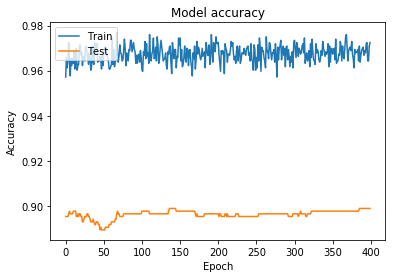

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
DD_Net.save_weights('weights/fine_lite.h5')

## With frame_sampling

In [44]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 10
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )


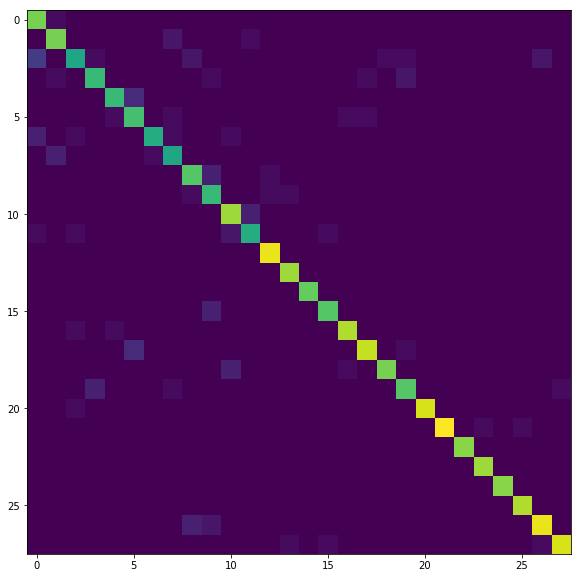

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()